# Making a KM-GAP model

The kinetic multi-layer model of gas-particle interations in aerosols and clouds (KM-GAP) is related to the KM-SUB models used in the rest of these tutorials. One of the main differences is that it can incorporate changes in the size of model layers as a function of the number of molecules in each layer. So particle size and film thickness can be followed during a reaction (https://doi.org/10.5194/acp-12-2777-2012). 

These models are computationally more expensive and need careful consideration. Here is how to create a KM-GAP model using the `oleic acid + ozone --> nonanal + products`. Note that in this case, we will include the volatile product nonanal in the model system and watch it evaporate. 

The model building steps are essentially the same as for KM-SUB, with a few additions. 

In [1]:
# importing the necessaries
import numpy as np
import multilayerpy
import multilayerpy.build as build 
import multilayerpy.simulate as simulate
import multilayerpy.optimize as optimize
import scipy

# useful to know what version of multilayerpy we are using
print(multilayerpy.__version__)

    
    MultilayerPy - build, run and optimise kinetic multi-layer models for 
    aerosol particles and films.
    
    Copyright (C) 2022 Adam Milsom

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
    Version: 0.0.2dev
    
    

0.0.2dev


In [2]:
# import the ModelType class
from multilayerpy.build import ModelType

# import the ReactionScheme class
from multilayerpy.build import ReactionScheme

# define the model type (KM-GAP in this case) and geometry (spherical or film)
mod_type = ModelType('km-gap','spherical')

# build the reaction tuple list, in this case only 1 tuple in the list (for 1 reaction)
# component 1 (oleic acid) reacts with component 2 (ozone)
reaction_tuple_list = [(1,2)]

# build the product tuple list, component 3 (products) and 4 (nonanal)
product_tuple_list = [(3,4)]

# now construct the reaction scheme
# we can give it a name and define the nuber of components as below
reaction_scheme = ReactionScheme(mod_type,name='Oleic acid ozonolysis',
                                                   reactants=reaction_tuple_list,
                                                products=product_tuple_list)

# let's print out a representation of the reaction scheme
reaction_scheme.display()

#########################################################
Reaction scheme: Oleic acid ozonolysis
Model type: km-gap
** No stoichiometry shown **
R1: 1 + 2 -----> 3 + 4 
#########################################################


In [3]:
# import ModelComponent class
from multilayerpy.build import ModelComponent

# making model components

# oleic acid
OA = ModelComponent(1,reaction_scheme,name='Oleic acid')

# ozone, declare that it is in the gas phase
O3 = ModelComponent(2,reaction_scheme,gas=True,name='Ozone') 

# products
prod = ModelComponent(3,reaction_scheme, name='Reaction products')

# nonanal
nonanal = ModelComponent(4,reaction_scheme, name='Nonanal')

# collect into a dictionary
model_components_dict = {'1':OA,
                        '2':O3,
                        '3':prod,
                        '4':nonanal}

In [4]:
# import DiffusionRegime class
from multilayerpy.build import DiffusionRegime

# making the diffusion dictionary
diff_dict = None 

# make diffusion regime
diff_regime = DiffusionRegime(mod_type,model_components_dict,diff_dict=diff_dict)

# call it to build diffusion code ready for the builder
diff_regime()


In [5]:
# import ModelBuilder class
from multilayerpy.build import ModelBuilder

# create the model object, ignore [1,2,3] etc at the end
model = ModelBuilder(reaction_scheme,model_components_dict,diff_regime)

# build the model. Will save a file, don't include the date in the model filename
model.build(date=False)

# print out the parameters required for the model to run
print(model.req_params)

{'Db_2', 'Td_2', 'delta_1', 'alpha_s_0_4', 'Db_1', 'Zgs_3', 'p_2', 'w_1', 'k_1_2_surf', 'w_2', 'Db_4', 'Zgs_4', 'delta_4', 'Db_3', 'p_3', 'p_4', 'T', 'Td_3', 'p_1', 'Td_1', 'Zgs_1', 'k_1_2', 'alpha_s_0_1', 'Td_4', 'delta_3', 'delta_2', 'w_4', 'alpha_s_0_2', 'alpha_s_0_3', 'w_3', 'Zgs_2'}


In [6]:
# import the Simulate class
from multilayerpy.simulate import Simulate

# import the Parameter class
from multilayerpy.build import Parameter

# build up the parameter dictionary - note the large amount of model parameters required for KM-GAP
param_dict = {'w_2':Parameter(3.6e4),
              'delta_1':Parameter(0.8e-7),
              'p_4':Parameter(0.4 / 760.0),
              'w_4':Parameter(590.0),
              'Zgs_2':Parameter(7.0e13),
              'Zgs_3':Parameter(0.0),
              'Td_1':Parameter(1e6),
              'Td_4':Parameter(1e-2,vary=True,bounds=(1e-6,1e-1)),
              'delta_4':Parameter(0.4e-7),
              'Td_2':Parameter(1e-2),
              'alpha_s_0_2':Parameter(4.2e-4,vary=True,bounds=(1e-4,1.0)),
              'Zgs_1':Parameter(0.0),
              'alpha_s_0_1':Parameter(1.0),
              'p_2':Parameter(1.0),
              'delta_3':Parameter(0.4e-7),
              'p_1':Parameter(0.0),
              'Td_3':Parameter(1e6),
              'Db_3':Parameter(1e-10),
              'alpha_s_0_4':Parameter(1.0),
              'k_1_2':Parameter(1.7e-15),
              'Db_2':Parameter(1e-5),
              'p_3':Parameter(0.0),
              'Zgs_4':Parameter(0.0),
              'w_3':Parameter(590.0),
              'w_1':Parameter(0.0),
              'T':Parameter(298.0),
              'Db_4':Parameter(1e-10),
              'Db_1':Parameter(1e-10),
              'alpha_s_0_3':Parameter(1.0),
              'k_1_2_surf':Parameter(6e-12),
              'delta_2':Parameter(0.4e-7)}


# make the simulate object with the model and parameter dictionary
sim = Simulate(model,param_dict)

# import the data to fit to later
from multilayerpy.simulate import Data
raw_data = np.genfromtxt('ziemann_data.csv',delimiter=',')

data = Data(raw_data)

sim.data = data

# define required parameters
n_layers = 10
rp = 0.2e-4 # radius in cm
time_span = [0,40] # in s
n_time = 999 # number of timepoints to save to output

#spherical V and A
# use simulate.make_layers function
V, A, layer_thick = simulate.make_layers(mod_type,n_layers,rp)

# initial conc. of everything

bulk_conc_dict = {'1':1.21e21,'2':0,'3':0,'4':0} # key=model component number, value=bulk conc
surf_conc_dict = {'1':9.68e13,'2':0,'3':0,'4':0} # key=model component number, value=surf conc
static_surf_conc_dict = {'1':9.68e13,'2':0,'3':0,'4':0}

# make initial concentrations but with additional keyword arguements required for KM-GAP
y0 = simulate.initial_concentrations(mod_type,bulk_conc_dict,surf_conc_dict,n_layers,
                                     parameter_dict=param_dict,
                                     static_surf_conc_dict = static_surf_conc_dict,
                                    V=V,A=A) 

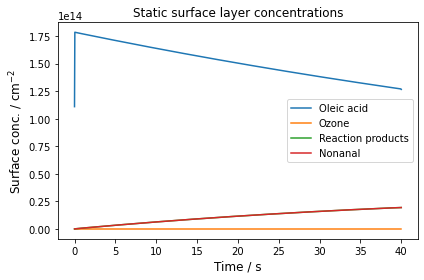

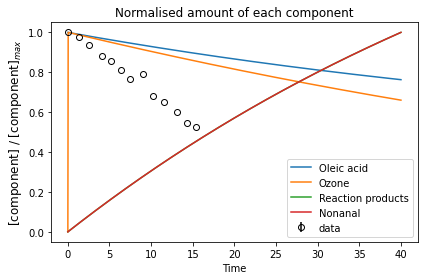

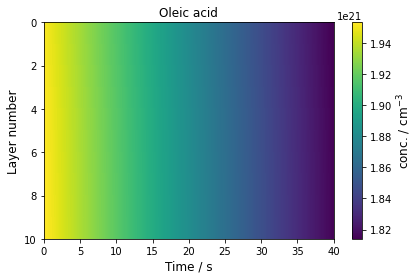

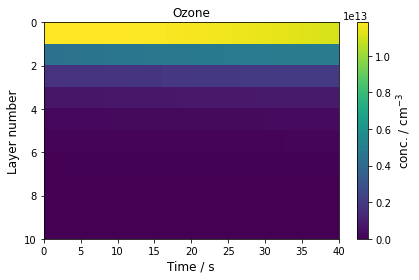

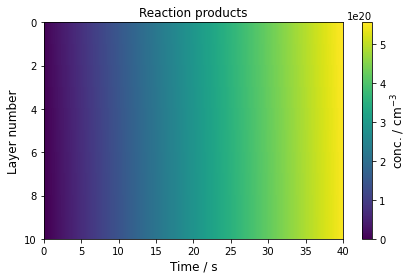

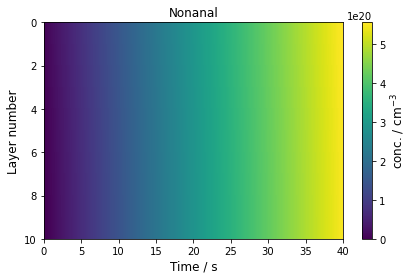

In [7]:
# now run the model
output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)


%matplotlib inline
# plot the model
sim.plot(norm=True)

# plot bulk concentrations
sim.plot_bulk_concs()

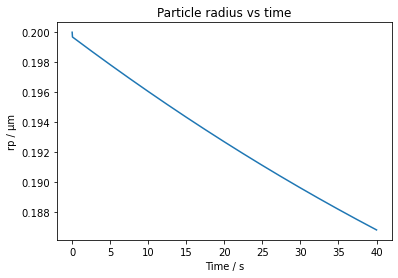

In [8]:
# get the particle radius as a function of time
rp_t = sim.rp_vs_t()

# plot rp vs t
import matplotlib.pyplot as plt

plt.figure()
plt.plot(output.t,rp_t*1e4)
plt.ylabel('rp / µm')
plt.xlabel('Time / s')
plt.title('Particle radius vs time')
plt.show()


Optimising using differential_evolution algorithm...

differential_evolution step 1: f(x)= 0.0412815
differential_evolution step 2: f(x)= 0.00458414
differential_evolution step 3: f(x)= 0.00458414
differential_evolution step 4: f(x)= 0.00458367
differential_evolution step 5: f(x)= 0.00224831
differential_evolution step 6: f(x)= 0.00224831
differential_evolution step 7: f(x)= 0.00224831
differential_evolution step 8: f(x)= 0.00224831
differential_evolution step 9: f(x)= 0.00224831
differential_evolution step 10: f(x)= 0.0022483
differential_evolution step 11: f(x)= 0.0022483
differential_evolution step 12: f(x)= 0.00189129
differential_evolution step 13: f(x)= 0.00189012
differential_evolution step 14: f(x)= 0.00189012
differential_evolution step 15: f(x)= 0.00189001
differential_evolution step 16: f(x)= 0.00189001
differential_evolution step 17: f(x)= 0.00188269
differential_evolution step 18: f(x)= 0.00188095
differential_evolution step 19: f(x)= 0.00188095
differential_evolution ste

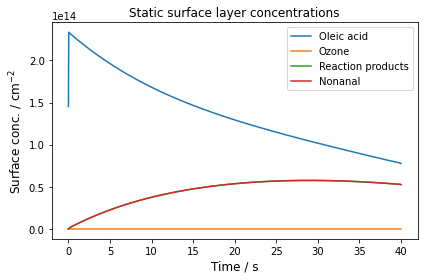

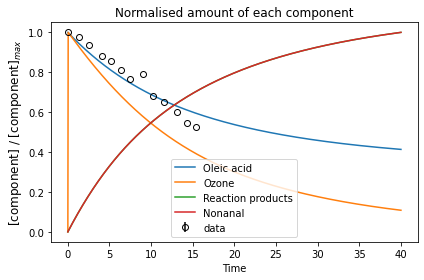

In [9]:
# model optimisation to the data

from multilayerpy.optimize import Optimizer

fitter = Optimizer(sim)

res = fitter.fit(method='differential_evolution',weighted=False) #set weighted to False as there are no uncertainties

sim.plot(norm=True)

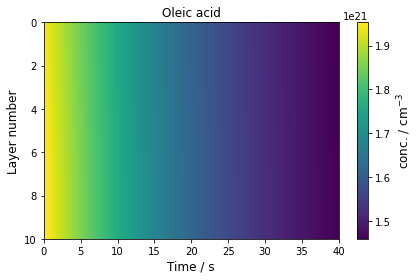

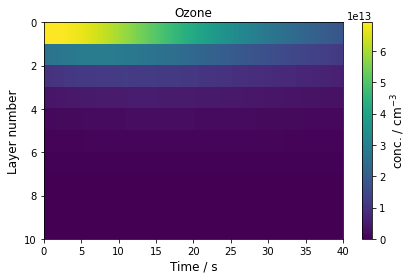

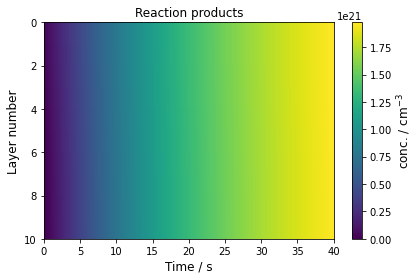

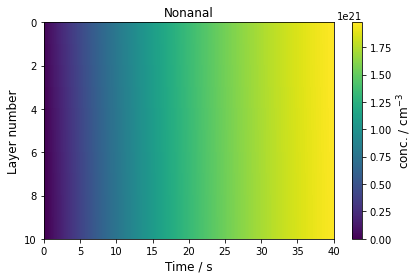

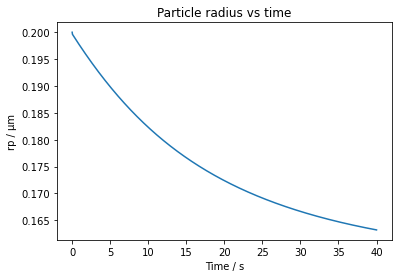

In [10]:
sim.plot_bulk_concs()

# get the particle radius as a function of time again
rp_t = sim.rp_vs_t()

# plot rp vs t
import matplotlib.pyplot as plt

plt.figure()
plt.plot(output.t,rp_t*1e4) # convert cm to µm
plt.ylabel('rp / µm')
plt.xlabel('Time / s')
plt.title('Particle radius vs time')
plt.show()